In [72]:
"""
Created on Wed May 19 09:55:27 2021

@author: domin
"""

import os
import pandas as pd
import numpy as np
import datetime
from cs.csv2pd import *
import matplotlib.pyplot as plt
from scipy import stats, signal


def creatingFarmFolder(path, csv_name):
    """creates folder for separate cows if it doesn't exist"""

    os.chdir(path)
    try:
        os.mkdir('./' + csv_name[:-4])
    except FileExistsError:
        pass
    os.chdir('./' + csv_name[:-4])


def all_equal(iterator):
    iterator = iter(iterator)
    try:
        first = next(iterator)
    except StopIteration:
        return True
    return all(first == x for x in iterator)


def separatingCows(dfFarm, colname4grouping='cow'):
    for cow in (dfFarm.groupby(dfFarm[colname4grouping])):
        cow[1].to_csv(str(cow[0]) + '.csv', index=False)

    csvList = os.listdir()
    csvList = [filename for filename in csvList if filename.endswith("csv")]
    return csvList


def get_prominences(df, col_index):
    array=df.iloc[:, col_index]
    
    peaks_h = signal.find_peaks(array)[0]
    prominences_h = signal.peak_prominences(array, peaks_h)[0]
    
    return peaks_h, prominences_h


def gamma_fitting(df, col_index, distance=1, CIlim=0.95):
    """
    
    """
    array=df.iloc[:, col_index]
    peaks, prominences = get_prominences(df = df, col_index = col_index)
    
    #gammafit
    alpha,loc,beta=stats.gamma.fit(prominences) #beta=scale
    #quantile=np.arange(0,1400,10)
    #PDF gamma
    xhist=plt.hist(prominences,density=True,
                   color="violet",alpha=0.5)
    quantile=np.arange(0,round(max(xhist[1])),10)
    R=stats.gamma.pdf(quantile,alpha,loc=loc,scale=beta)
    #IC
    IC=stats.gamma.interval(CIlim,a=alpha,loc=loc,scale=beta)
    plt.vlines(IC[1],ymin=min(R),ymax=max(R),color="red", label="CI = {}".format(CIlim))
    plt.plot(quantile,R,color="darkblue")
    plt.title("Fitting gamma distribution to signal peaks")
    plt.legend()
    plt.show()
    
    
    #plot peaks that are > ICmax
    peaksGamma=peaks[prominences>IC[1]]
    plt.figure(figsize=(16,5))
    plt.plot(df.index, array, 'lightpink', label='data',alpha=0.5)
    plt.scatter(df.index[peaksGamma],array[peaksGamma], edgecolors="darkblue",label='monthly increase in activity', alpha = 0.9)
    plt.legend()
    plt.title("Daily activity")
    plt.show()

In [16]:
path2cow = "C:\\Users\\domin\\Documents\\SCHOOL\\STAGE\\data\\cows_mice\\cows\\farm1\\6601.csv"
df = pd.read_csv(path2cow, parse_dates=True, index_col="timestamp")

In [24]:
df.head()

,cow,WALK,SLEEP,EAT,ACTIVITY_LEVEL,A,B,B2,B3,B4,C,D,E,F,F2,OK
timestamp,,,,,,,,,,,,,,,,
2018-10-26 10:00:00,6601,1235.313,102.471,2262.210,1124.20995,0,0,0,0,0,0,0,0,0,0,1
2018-10-26 11:00:00,6601,2523.211,155.482,865.378,731.41166,0,0,0,0,0,0,0,0,0,0,1
2018-10-26 12:00:00,6601,702.903,2491.896,405.195,-290.48970,0,0,0,0,0,0,0,0,0,0,1
2018-10-26 13:00:00,6601,901.521,1322.041,1376.432,418.27537,0,0,0,0,0,0,0,0,0,0,1
2018-10-26 14:00:00,6601,36.456,3563.538,0.000,-813.78078,0,0,0,0,0,0,0,0,0,0,1


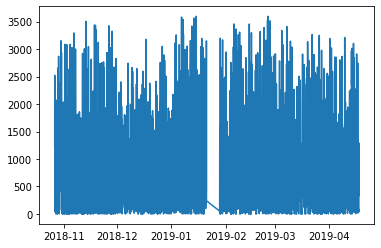

In [25]:
plt.plot(df.iloc[:,1])

In [61]:
df_res = df.resample("12H").mean()

In [57]:
df_res_cut = df_res[:"2019-03-03"]

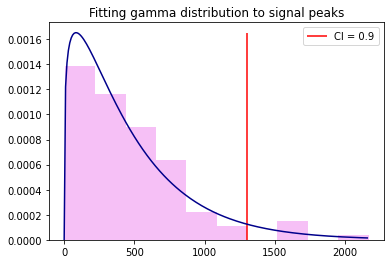

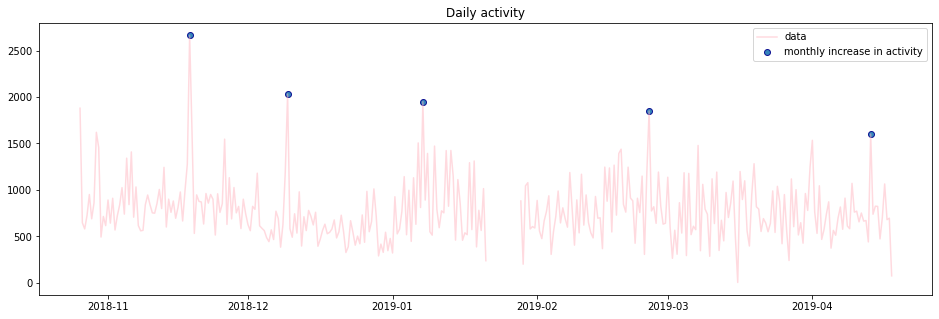

In [73]:
gamma_fitting(df=df_res, col_index=1, distance=1, CIlim=0.90)

In [ ]:
def cuttingOutNas(csvList, distance):
    for i in range(len(csvList)):
        cow = pd.read_csv(csvList[i], header=0, decimal='.',
                          parse_dates=[0])
        cow = new_names(cow)
        cow = setTimeInx(df=cow, col_index=0)
        cow = intrpl_times(df=cow)
        # time range of nulls
        nullValues = [list(cow[cow.iloc[:, i].isnull()].index) for i in range(1, 5)]  # len(cow.columns))]
        if all_equal(nullValues):
            nullValues = nullValues[0]
        else:
            np.concatenate(nullValues)
            nullValues = np.unique(nullValues)
        null_range = pd.date_range(start=nullValues[0], end=nullValues[-1])

        Slice1 = cow[cow.index < null_range[0]]
        Slice2 = cow[cow.index > null_range[-1]]
        Slice = (Slice1, Slice2)

        for j in range(1, 5):
            print("Cow n." + str(csvList[i][:-4]) + " , col: " + str(cow.columns[j]))
            normal_fitting2(df=Slice, oriDF=cow, col_index=j, distance=distance)


def farm2CSV2cows(farmNumber=1, path= "../data/cows",
                  distance=1):
    os.chdir(path)
    csvList = os.listdir()
    csvList = [filename for filename in csvList if filename.endswith("csv")]

    farm_i = farmNumber - 1  # Farm number YOU WANT TO PROCESS NOW -----------------------------

    csv_name = csvList[farm_i]
    df = pd.read_csv(csvList[farm_i], header=0, parse_dates=True)
    df.iloc[:, 2] = [0 if i == 24 else i for i in df.iloc[:, 2]]  # set midnight to 0, not 24
    df.iloc[:, 2] = [str(i) + ':00:00' for i in df.iloc[:, 2]]  # add minutes and seconds in time col
    df['date'] = pd.to_datetime(df['date'])  # change to date format
    timestamp = pd.to_datetime(df['date'].dt.date.astype(str)
                               + ' '
                               + df['hour'].astype(str)),  # put date and time together

    df.drop(['date', 'hour'], inplace=True, axis=1)  # delete the cols since it will be index
    df['timestamp'] = np.array(timestamp[0])
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    df.iloc[:, 0] = [day + datetime.timedelta(days=1) if day.hour == 0 else day for day in
                     df.iloc[:, 0]]  # new day if midnight

    creatingFarmFolder(path=path, csv_name=csv_name)

    separatingCows(dfFarm=df, colname4grouping="cow")

    csvList = os.listdir()
    csvList = [filename for filename in csvList if filename.endswith("csv")]

    cuttingOutNas(csvList=csvList, distance=distance)